# Chapter 2: Introduction to TensorFlow

Here you can find all the exercises for the Chapter 2 of NLP with TensorFlow (2nd Edition). The 2nd edition is written using TensorFlow 2. There are quite a differences between TensorFlow 1 and Tensorflow 2.
    
## Differences between TensorFlow 1 and TensorFlow 2
* There are no sessions in TensorFlow 2. You write a function with TensorFlow operations and you will be able to see the results immediately with Eager execution enabled.
* Instead of creating large static dataflow graphs using tf operations, in TensorFlow 2, you can write atomic functions and decorate them with `tf.function()` to create the dataflow graph automatically.
* TensorFlow 2 variables without a reference are garbage collected.
* In TensorFlow 2, you can use `GradientTape` to record gradients required to optimize models.

## Importing Required Libraries

In [2]:
import tensorflow as tf
# Making sure we have the correct TF version
print('TensorFlow version => ',tf.__version__)
import numpy as np
import os
import matplotlib.pyplot as plt
# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

TensorFlow version =>  2.4.0


## Sigmoid Example - Feeding inputs as a NumPy array
Here we calculate the sigmoid example by feeding in inputs as a NumPy array. 

In [3]:
@tf.function
def layer(x, W, b):    
    # Building the graph
    h = tf.nn.sigmoid(tf.matmul(x,W) + b) # Operation to be performed
    return h

x = np.array([[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]], dtype=np.float32) 

# Variable
init_w = tf.initializers.RandomUniform(minval=-0.1, maxval=0.1)(shape=[10,5])
W = tf.Variable(init_w, dtype=tf.float32, name='W') 
# Variable
init_b = tf.initializers.RandomUniform()(shape=[5])
b = tf.Variable(init_b, dtype=tf.float32, name='b') 

h = layer(x,W,b)
print("h = {}".format(h))

h = [[0.5401469  0.5006227  0.524282   0.50950253 0.48132703]]


## Feeding inputs as Tensorflow tensors

Now we make the same calculations with the input as an immutable tensor

In [4]:
@tf.function
def layer(x, W, b):    
    # Building the graph
    h = tf.nn.sigmoid(tf.matmul(x,W) + b) # Operation to be performed
    return h

# Building the graph

# A pre-loaded input
x = tf.constant(value=[[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]],dtype=tf.float32,name='x') 

# Variable
init_w = tf.initializers.RandomUniform(minval=-0.1, maxval=0.1)(shape=[10,5])
W = tf.Variable(init_w, dtype=tf.float32, name='W') 
# Variable
init_b = tf.initializers.RandomUniform()(shape=[5])
b = tf.Variable(init_b, dtype=tf.float32, name='b') 

h = layer(x,W,b)
print("h = {}".format(h))
print("h is of type {}".format(type(h)))

h = [[0.49002668 0.4973774  0.42448547 0.52314764 0.47204968]]
h is of type <class 'tensorflow.python.framework.ops.EagerTensor'>


## `tf.data` API
We now create a data pipleline to read inputs. Data pipeline is an efficient way of reading data when you have to read lots of data stored externally. Here you will be using several text files containing data from the famous Iris dataset, which as various atrributes of several flowers. However some of this data has been corrupted, resulting in negative values. We will write an input pipeline which will read the data from the file, and then print out the corrupted data rows.

In [5]:
# The filename queue
filenames = ['./iris.data.{}'.format(i) for i in range(1,4)]

# Defining a dataset object that accepts CSV type data
dataset = tf.data.experimental.CsvDataset(
    filenames, [tf.float32, tf.float32, tf.float32, tf.float32, tf.string])

# X will be the first 4 columns in the CSV file
# tf.stack() combines the individual features to a single tensor
x_dataset = dataset.map(lambda x1,x2,x3,x4,y: tf.stack([x1,x2,x3,x4]))

# Creating the Y dataset as class labels
y_dataset = dataset.map(lambda x1,x2,x3,x4,y: y)

# Combining the X and Y datasets
dataset = dataset.zip((x_dataset,y_dataset))

# Iterating through the dataset
for next_element in dataset:
    x, y = next_element[0].numpy(), next_element[1].numpy().decode('ascii')
    if np.min(x)<0.0:
        print("(corrupted) X => {}\tY => {}".format(x,y))
    

(corrupted) X => [ 5.8 -4.   1.2  0.2]	Y => Iris-setosa
(corrupted) X => [ 4.6  3.6 -1.   0.2]	Y => Iris-setosa
(corrupted) X => [ 4.7 -3.2  1.6  0.2]	Y => Iris-setosa
(corrupted) X => [-5.   3.5  1.3  0.3]	Y => Iris-setosa
(corrupted) X => [-5.1  3.8  1.6  0.2]	Y => Iris-setosa
(corrupted) X => [ 6.9 -3.1  4.9  1.5]	Y => Iris-versicolor
(corrupted) X => [-5.2  2.7  3.9  1.4]	Y => Iris-versicolor
(corrupted) X => [ 5.8  2.7  4.1 -1. ]	Y => Iris-versicolor
(corrupted) X => [ 6.1 -2.8  4.7  1.2]	Y => Iris-versicolor
(corrupted) X => [ 5.4  3.  -4.5  1.5]	Y => Iris-versicolor
(corrupted) X => [ 7.1 -3.   5.9  2.1]	Y => Iris-virginica
(corrupted) X => [ 5.7  2.5  5.  -2. ]	Y => Iris-virginica
(corrupted) X => [-6.   2.2  5.   1.5]	Y => Iris-virginica
(corrupted) X => [ 7.2 -3.2  6.   1.8]	Y => Iris-virginica
(corrupted) X => [ 6.1  2.6  5.6 -1.4]	Y => Iris-virginica


## Filtering all the corrupted rows

Here we will use the `dataset.filter()` function to filter out any corrupted inputs. Corrupted inputs in this case are dected by checking if the minimum value of each row is less than zero.

In [6]:
# Adding this to avoid strange behaviors running the cell multiple times
dataset = dataset.zip((x_dataset,y_dataset))
# Filtering data with a negative value in one of the X columns
dataset = dataset.filter(lambda x,y: tf.reduce_min(x)>0)

# Iterating the dataset
no_corrupt = True
for next_element in dataset:
    x, y = next_element[0].numpy(), next_element[1].numpy()
    if np.any(x<0.0):
        print("Aha! Detected a corrupted item: ", next_element[0].numpy())
        no_corrupt = False

if no_corrupt:
    print("No corrupted items detected")


No corrupted items detected


## Iterating the dataset in batches

One of the most common behaviors when training a model is to iterate through the dataset in batches, while training or predicting using a model. The `dataset.batch()` function provides a convenient way to do so. Here you can see that we are using a batch_size of 5 and getting 5 rows of data at a time during iterations.

In [7]:
# Adding this to avoid strange behaviors running the cell multiple times
dataset = dataset.zip((x_dataset,y_dataset))

# Creating batches of 5
batch_size = 5
dataset = dataset.batch(batch_size=batch_size)

for next_element in dataset:
    x, y = next_element[0].numpy(), next_element[1].numpy()    
    print("x.shape = {}, y.shape = {}".format(x.shape, y.shape))

x.shape = (5, 4), y.shape = (5,)
x.shape = (5, 4), y.shape = (5,)
x.shape = (5, 4), y.shape = (5,)
x.shape = (5, 4), y.shape = (5,)
x.shape = (5, 4), y.shape = (5,)
x.shape = (5, 4), y.shape = (5,)
x.shape = (5, 4), y.shape = (5,)
x.shape = (5, 4), y.shape = (5,)
x.shape = (5, 4), y.shape = (5,)
x.shape = (5, 4), y.shape = (5,)
x.shape = (5, 4), y.shape = (5,)
x.shape = (5, 4), y.shape = (5,)
x.shape = (5, 4), y.shape = (5,)
x.shape = (5, 4), y.shape = (5,)
x.shape = (5, 4), y.shape = (5,)
x.shape = (5, 4), y.shape = (5,)
x.shape = (5, 4), y.shape = (5,)
x.shape = (5, 4), y.shape = (5,)
x.shape = (5, 4), y.shape = (5,)
x.shape = (5, 4), y.shape = (5,)
x.shape = (5, 4), y.shape = (5,)
x.shape = (5, 4), y.shape = (5,)
x.shape = (5, 4), y.shape = (5,)
x.shape = (5, 4), y.shape = (5,)
x.shape = (5, 4), y.shape = (5,)
x.shape = (5, 4), y.shape = (5,)
x.shape = (5, 4), y.shape = (5,)
x.shape = (5, 4), y.shape = (5,)
x.shape = (5, 4), y.shape = (5,)
x.shape = (5, 4), y.shape = (5,)
x.shape = 

## Bonus: Converting class labels to class IDs

You have seen that, `y` here in fact is a string. However we need to convert this to a class ID (or an Integer) in order to use `y` to train a model. For that you can create a lookup table using the `tf.lookup.StaticVocabularyTable` object.

In [8]:
# The filename queue
filenames = ['./iris.data.{}'.format(i) for i in range(1,4)]

# Defining a dataset object that accepts CSV type data
dataset = tf.data.experimental.CsvDataset(
    filenames, [tf.float32, tf.float32, tf.float32, tf.float32, tf.string])

# X will be the first 4 columns in the CSV file
x_dataset = dataset.map(lambda x1,x2,x3,x4,y: (x1,x2,x3,x4))

# Converting the string label to an integer
table = tf.lookup.StaticVocabularyTable(
    tf.lookup.KeyValueTensorInitializer(
        [b'Iris-setosa', b'Iris-versicolor', b'Iris-virginica'],
        tf.constant([0,1,2], dtype=tf.int64)),
    num_oov_buckets=1
)

# Creating the Y dataset as class labels
y_dataset = dataset.map(lambda x1,x2,x3,x4,y: table.lookup(y))

# Combining the X and Y datasets
dataset = dataset.zip((x_dataset,y_dataset))
# Columns of x are shown as a list of tensors, 
# instead we would like to have a single tensor with all columns
dataset = dataset.map(lambda x,y: (tf.stack(x),y))

for next_element in dataset:
    x, y = next_element[0].numpy(), next_element[1].numpy()
    if np.min(x)<0.0:
        print("(corrupted) X => {}\tY => {}".format(x,y))

(corrupted) X => [ 5.8 -4.   1.2  0.2]	Y => 0
(corrupted) X => [ 4.6  3.6 -1.   0.2]	Y => 0
(corrupted) X => [ 4.7 -3.2  1.6  0.2]	Y => 0
(corrupted) X => [-5.   3.5  1.3  0.3]	Y => 0
(corrupted) X => [-5.1  3.8  1.6  0.2]	Y => 0
(corrupted) X => [ 6.9 -3.1  4.9  1.5]	Y => 1
(corrupted) X => [-5.2  2.7  3.9  1.4]	Y => 1
(corrupted) X => [ 5.8  2.7  4.1 -1. ]	Y => 1
(corrupted) X => [ 6.1 -2.8  4.7  1.2]	Y => 1
(corrupted) X => [ 5.4  3.  -4.5  1.5]	Y => 1
(corrupted) X => [ 7.1 -3.   5.9  2.1]	Y => 2
(corrupted) X => [ 5.7  2.5  5.  -2. ]	Y => 2
(corrupted) X => [-6.   2.2  5.   1.5]	Y => 2
(corrupted) X => [ 7.2 -3.2  6.   1.8]	Y => 2
(corrupted) X => [ 6.1  2.6  5.6 -1.4]	Y => 2


## Comparison Operators

Here we discuss some operators that allows us to compare two tensors element-wise

In [9]:
# Let's assume the following values for x and y
# x (2-D tensor) => [[1,2],[3,4]]
# y (2-D tensor) => [[4,3],[3,2]]
x = tf.constant([[1,2],[3,4]], dtype=tf.int32)
y = tf.constant([[4,3],[3,2]], dtype=tf.int32)

# Checks if two tensors are equal element-wise and returns a boolean tensor
# x_equal_y => [[False,False],[True,False]]
x_equal_y = tf.equal(x, y, name=None) 

# Checks if x is less than y element-wise and returns a boolean tensor
# x_less_y => [[True,True],[True,False]]
x_less_y = tf.less(x, y, name=None) 

# Checks if x is greater or equal than y element-wise and returns a boolean tensor
# x_great_equal_y => [[False,False],[True,True]]
x_great_equal_y = tf.greater_equal(x, y, name=None) 

# Selects elements from x and y depending on whether,
# the condition is satisfied (select elements from x)
# or the condition failed (select elements from y)
condition = tf.constant([[True,False],[True,False]],dtype=tf.bool)
# x_cond_y => [[1,3],[3,2]]
x_cond_y = tf.where(condition, x, y, name=None) 

print('Is X == Y (element-wise)?')
print(x_equal_y.numpy())

print('\nIs X < Y (element-wise)?')
print(x_less_y.numpy())

print('\nIs X >= Y (element-wise)?')
print(x_great_equal_y.numpy())

print('\nX or Y depending on the condition (element-wise)')
print(x_cond_y.numpy())


Is X == Y (element-wise)?
[[False False]
 [ True False]]

Is X < Y (element-wise)?
[[ True  True]
 [False False]]

Is X >= Y (element-wise)?
[[False False]
 [ True  True]]

X or Y depending on the condition (element-wise)
[[1 3]
 [3 2]]


## Mathematical Operations
Here we perform several mathematical opeartions you are often comfortable with

In [10]:
# Let's assume the following values for x and y
# x (2-D tensor) => [[1,2],[3,4]]
# y (2-D tensor) => [[4,3],[3,2]]
x = tf.constant([[1,2],[3,4]], dtype=tf.float32)
y = tf.constant([[4,3],[3,2]], dtype=tf.float32)

# Add two tensors x and y in an element-wise fashion
# x_add_y => [[5,5],[6,6]]
x_add_y_1 = tf.add(x, y) 
x_add_y_2 = x + y

# Performs matrix multiplication (not element-wise)
# x_mul_y => [[10,7],[24,17]]
x_mul_y = tf.matmul(x, y) 

# Compute natural logarithm of x element-wise
# equivalent to computing ln(x)
# log_x => [[0,0.6931],[1.0986,1.3863]]
log_x = tf.math.log(x) 

# Performs reduction operation across the specified axis
# x_sum_1 => [3,7]
x_sum_1 = tf.reduce_sum(x, axis=[1], keepdims=False)

# x_sum_2 => [[4],[6]]
x_sum_2 = tf.reduce_sum(x, axis=[0], keepdims=True) 

# Segments the tensor according to segment_ids (items with same id in
# the same segment) and computes a segmented sum of the data

data = tf.constant([1,2,3,4,5,6,7,8,9,10], dtype=tf.float32)
segment_ids = tf.constant([0,0,0,1,1,2,2,2,2,2 ], dtype=tf.int32)
# x_seg_sum => [6,9,40]
x_seg_sum = tf.math.segment_sum(data, segment_ids) 

print('X + Y')
print(x_add_y_1.numpy())
print('\n XY')
print(x_mul_y.numpy())
print('\n log(x)')
print(log_x.numpy())
print('\n X sum over axis 1')
print(x_sum_1.numpy())
print('\n X sum over axis 0')
print(x_sum_2.numpy())
print('\n Segemented sum of a vector')
print(x_seg_sum.numpy())

X + Y
[[5. 5.]
 [6. 6.]]

 XY
[[10.  7.]
 [24. 17.]]

 log(x)
[[0.        0.6931472]
 [1.0986123 1.3862944]]

 X sum over axis 1
[3. 7.]

 X sum over axis 0
[[4. 6.]]

 Segemented sum of a vector
[ 6.  9. 40.]


## Scatter operation
Scatter operation refers to using indexing or slicing to change the values in a tensor.

In [11]:
v = tf.Variable(tf.constant([[1,9],[3,10],[5,11]],dtype=tf.float32),name='ref')
# Changing the 0th row in v
v[0].assign([-1, -9])
print('\nref (after changing row=0)\n', v)

v = tf.Variable(tf.constant([[1,9],[3,10],[5,11]],dtype=tf.float32),name='ref')
# Changing the value at 1st row, 1st column in v
v[1,1].assign(-10)
print('\nref (after changing row=1, col=1)\n', v)

v = tf.Variable(tf.constant([[1,9],[3,10],[5,11]],dtype=tf.float32),name='ref')
# Changing the values of rows starting from 1st to end in 0th column of v
v[1:,0].assign([-3,-5])
print('\nref (after changing row=1:, col=0)\n', v)


ref (after changing row=0)
 <tf.Variable 'ref:0' shape=(3, 2) dtype=float32, numpy=
array([[-1., -9.],
       [ 3., 10.],
       [ 5., 11.]], dtype=float32)>

ref (after changing row=1, col=1)
 <tf.Variable 'ref:0' shape=(3, 2) dtype=float32, numpy=
array([[  1.,   9.],
       [  3., -10.],
       [  5.,  11.]], dtype=float32)>

ref (after changing row=1:, col=0)
 <tf.Variable 'ref:0' shape=(3, 2) dtype=float32, numpy=
array([[ 1.,  9.],
       [-3., 10.],
       [-5., 11.]], dtype=float32)>


## Gather operation

Gather operation refers to using indexing or slicing to retrieve values in a tensor.

In [12]:
t = tf.constant([[1,9],[3,10],[5,11]],dtype=tf.float32)
# Getting the 0th row in v
print('t[0] =',t[0].numpy())
# Getting the value at 1st row, 1st column in v
print('t[1,1] =',t[1,1].numpy())
# Getting the values of rows starting from 1st to end in 0th column of v
print('t[1:,0] =',t[1:,0].numpy())

t[0] = [1. 9.]
t[1,1] = 10.0
t[1:,0] = [3. 5.]


## 2-Dimensional Operations (2D Convolution and 2D Max pooling)
2D Convolution and Max pooling are two operation you perform on a tensor over the width and height axes. These operations are often used in convolution neural networks.

In [13]:
x = tf.constant(
    [[
        [[1],[2],[3],[4]],
        [[4],[3],[2],[1]],
        [[5],[6],[7],[8]],
        [[8],[7],[6],[5]]
    ]],
    dtype=tf.float32)

x_filter = tf.constant(
    [
        [
            [[0.5]],[[1]]
        ],
        [
            [[0.5]],[[1]]
        ]
    ],
    dtype=tf.float32)

x_stride = [1,1,1,1]
x_padding = 'VALID'

x_conv = tf.nn.conv2d(
    input=x, filters=x_filter,
    strides=x_stride, padding=x_padding
)

print('\n2-D Convolution operation')
print(x_conv.numpy())

x = tf.constant(
    [[
        [[1],[2],[3],[4]],
        [[4],[3],[2],[1]],
        [[5],[6],[7],[8]],
        [[8],[7],[6],[5]]
    ]],
    dtype=tf.float32)

x_ksize = [1,2,2,1]
x_stride = [1,2,2,1]
x_padding = 'VALID'

x_pool = tf.nn.max_pool2d(
    input=x, ksize=x_ksize,
    strides=x_stride, padding=x_padding
)

print('\nMax pooling operation')
print(x_pool.numpy())

NotFoundError: No algorithm worked! [Op:Conv2D]

## Loss Functions
Here we define several well-known loss functions that are commonly used in optimizing neural networks.
1. Mean Squared Error (MSE)
 * $MSE = (1/N)\sum_{i=1}^{N} {(x_i-\hat{x}_i)}^2$
 
2. Cross Entropy Loss (CE)
 * $CE = -(1/N)\sum_{i=1}^{N}y_ilog(\hat{y}_i) + (1-y_i)log(1-\hat{y}_i)$

In [14]:
# Returns half of L2 norm of t given by sum(t**2)/2
x = tf.constant([[2,4],[6,8]],dtype=tf.float32)
x_hat = tf.constant([[1,2],[3,4]],dtype=tf.float32)
# MSE = (1**2 + 2**2 + 3**2 + 4**2)/2 = 15
MSE = tf.nn.l2_loss(x-x_hat)

# A common loss function used in neural networks to optimize the network
# Calculating the cross_entropy with logits (unnormalized outputs of the last layer)
# instead of probabilsitic outputs leads to better numerical stabilities

y = tf.constant([[1,0],[0,1]],dtype=tf.float32)
y_hat = tf.constant([[3,1],[2,5]],dtype=tf.float32)
# This function alone doesnt average the cross entropy losses of all data points,
# You need to do that manually using reduce_mean function
CE = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_hat,labels=y))

print('MSE Loss: ',MSE.numpy())
print('CE Loss: ',CE.numpy())

MSE Loss:  15.0
CE Loss:  0.08775769


## Stochastic Optimization
Here we discuss how to implement optimization with TensorFlow. The objective of this example is to find the mininum point of a given function. For this example, we will use a simple quadratic function where $y = x^2$. We will start at an arbitrary point (say $x=2$) and keep minimizing $y$ until we reach the minimum $y$.

Step:  0 , x:  1.600000023841858 , y:  4.0
Step:  1 , x:  1.2799999713897705 , y:  2.56000018119812
Step:  2 , x:  1.0239999294281006 , y:  1.6383999586105347
Step:  3 , x:  0.8191999197006226 , y:  1.0485758781433105
Step:  4 , x:  0.6553599238395691 , y:  0.6710885167121887


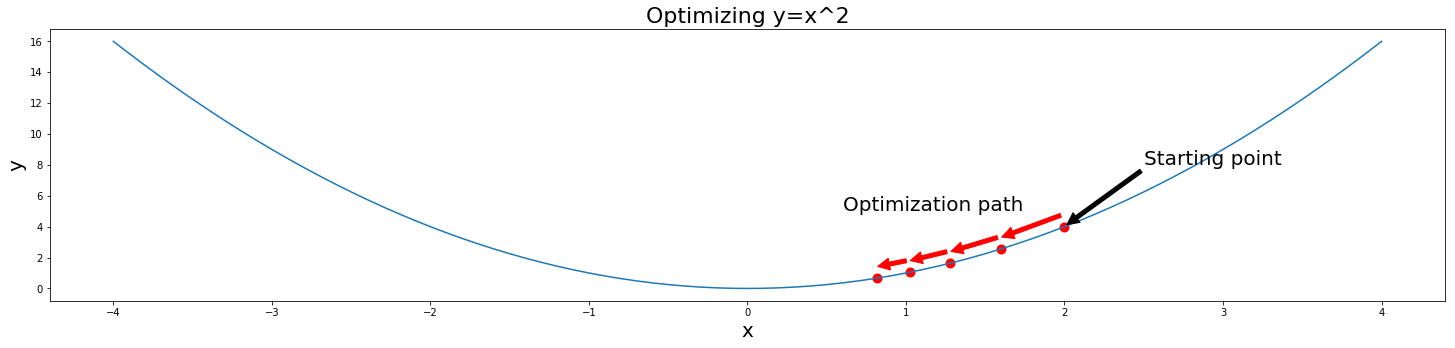

In [73]:
# Optimizers play the role of tuning neural network parameters so that their task error is minimal
# For example task error can be the cross_entropy error for a classification task
tf_x = tf.Variable(tf.constant(2.0,dtype=tf.float32),name='x') 
optimizer = tf.optimizers.SGD(learning_rate=0.1)

# Optimizing tf_x using gradient tape
x_series, y_series = [],[]
for step in range(5):    
    x_series.append(tf_x.numpy().item())
    with tf.GradientTape() as tape:
        tf_y = tf_x**2
        
    gradients = tape.gradient(tf_y, tf_x)
    optimizer.apply_gradients(zip([gradients], [tf_x]))
    print('Step: ',step, ', x: ',tf_x.numpy().item(), ', y: ',tf_y.numpy().item())
    
    y_series.append(tf_y.numpy().item())

# Plotting the graph
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(w=25,h=5)
ax.plot(np.arange(-4,4.1,0.1),np.arange(-4,4.1,0.1)**2)
ax.scatter(x_series,y_series,c='red',linewidths=4)

x_offset, y_offset = 0.02, 0.75
ax.annotate('Starting point', xy=(2.01, 4.1), xytext=(2.5, 8),
            arrowprops=dict(facecolor='black', shrink=0.01),fontsize=20
            )

ax.annotate('Optimization path', xy=(2.01, 4.1), xytext=(0.6, 5),
            arrowprops=None,fontsize=20
            )

for index,(x,y) in enumerate(zip(x_series,y_series)):
    if index == len(x_series)-1:
        break
    ax.annotate('', xy=(x_series[index+1], y_series[index+1]+y_offset), xytext=( x - x_offset, y + y_offset),
                arrowprops=dict(facecolor='red', edgecolor='red', shrink=0.01),fontsize=20
                )

ax.set_xlabel('x',fontsize=20)
ax.set_ylabel('y',fontsize=20)
ax.set_title('Optimizing y=x^2',fontsize=22)
fig.savefig('optimization.png')

## Controlling the flow of operations

In [76]:
x = tf.Variable(tf.constant(2.0), name='x')
assign_op = x.assign(x+5)
with tf.control_dependencies([assign_op]):
    z = x*2

print('x=',x.numpy())
print('z=',z.numpy())

x= 7.0
z= 14.0


# MNIST Classification

## Download and Prepare Data

The code below downloads the MNIST data set from source, reshapes the images to `[number_of_training_samples, single_image_size]` matrix and standardize (make zero-mean unit-variance) images. Then we do the same for testing images as well.

In [23]:
os.makedirs('data', exist_ok=True)

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data(path=os.path.join(os.getcwd(), 'data', 'mnist.npz'))

print("(Before) x_train has shape: {}".format(x_train.shape))
print("(Before) x_test has shape: {}".format(x_test.shape))

print("(Before) x_train has - min: {}, max: {}".format(np.min(x_train), np.max(x_train)))
print("(Before) x_test has - min: {}, max: {}".format(np.min(x_test), np.max(x_test)))

x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

print("(After) x_train has shape: {}".format(x_train.shape))
print("(After) x_test has shape: {}".format(x_test.shape))

x_train = (x_train - np.mean(x_train, axis=1, keepdims=True))/np.std(x_train, axis=1, keepdims=True)
x_test = (x_test - np.mean(x_test, axis=1, keepdims=True))/np.std(x_test, axis=1, keepdims=True)

print("(After) x_train has - min: {}, max: {}".format(np.min(x_train), np.max(x_train)))
print("(After) x_test has - min: {}, max: {}".format(np.min(x_test), np.max(x_test)))

11493376/11490434 [==============================] - 5s 0us/step
(Before) x_train has shape: (60000, 28, 28)
(Before) x_test has shape: (10000, 28, 28)
(Before) x_train has - min: 0, max: 255
(Before) x_test has - min: 0, max: 255
(After) x_train has shape: (60000, 784)
(After) x_test has shape: (10000, 784)
(After) x_train has - min: -0.8508020140306101, max: 7.770145734421186
(After) x_test has - min: -0.731905259880747, max: 7.57798901103678


In [27]:
batch_size = 100
img_width, img_height = 28,28
input_size = img_height * img_width
num_labels = 10

def mnist_model():
    """ Defining the model using Keras sequential API """
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(500, activation='relu'),
        tf.keras.layers.Dense(250, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    return model

# Defining the model, optimizer and a loss function
model = mnist_model()
optimizer = tf.keras.optimizers.RMSprop()
loss_fn = tf.keras.losses.CategoricalCrossentropy()
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['acc'])

NUM_EPOCHS = 10

""" Model training """    

# Creating onehot encoded labels
y_onehot_train = np.zeros((y_train.shape[0], num_labels), dtype=np.float32)
y_onehot_train[np.arange(y_train.shape[0]), y_train] = 1.0

# Training Phase 
train_history = model.fit(x_train,y_onehot_train, batch_size=batch_size, epochs=NUM_EPOCHS, validation_split=0.2)

""" Testing phase """

# Test inputs and targets
y_onehot_test = np.zeros((y_test.shape[0], num_labels), dtype=np.float32)
y_onehot_test[np.arange(y_test.shape[0]), y_test] = 1.0

# Evaulte on test data
test_res = model.evaluate(x_test, y_onehot_test, batch_size=batch_size)

print("Testing Results: ")
print("\tLoss: {}".format(test_res[0]))
print("\tAccuracy: {}".format(test_res[0]))

Epoch 1/10
480/480 [==============================] - 1s 2ms/step - loss: 0.4387 - acc: 0.8721 - val_loss: 0.1161 - val_acc: 0.9650
Epoch 2/10
480/480 [==============================] - 1s 1ms/step - loss: 0.0958 - acc: 0.9708 - val_loss: 0.0930 - val_acc: 0.9725
Epoch 3/10
480/480 [==============================] - 1s 1ms/step - loss: 0.0622 - acc: 0.9810 - val_loss: 0.1189 - val_acc: 0.9692
Epoch 4/10
480/480 [==============================] - 1s 1ms/step - loss: 0.0478 - acc: 0.9846 - val_loss: 0.0917 - val_acc: 0.9768
Epoch 5/10
480/480 [==============================] - 1s 1ms/step - loss: 0.0354 - acc: 0.9888 - val_loss: 0.1152 - val_acc: 0.9743
Epoch 6/10
480/480 [==============================] - 1s 1ms/step - loss: 0.0302 - acc: 0.9909 - val_loss: 0.1306 - val_acc: 0.9745
Epoch 7/10
480/480 [==============================] - 1s 1ms/step - loss: 0.0268 - acc: 0.9922 - val_loss: 0.1161 - val_acc: 0.9796
Epoch 8/10
480/480 [==============================] - 1s 1ms/step - loss: 0.

## Visualizing the Loss and the Accuracy

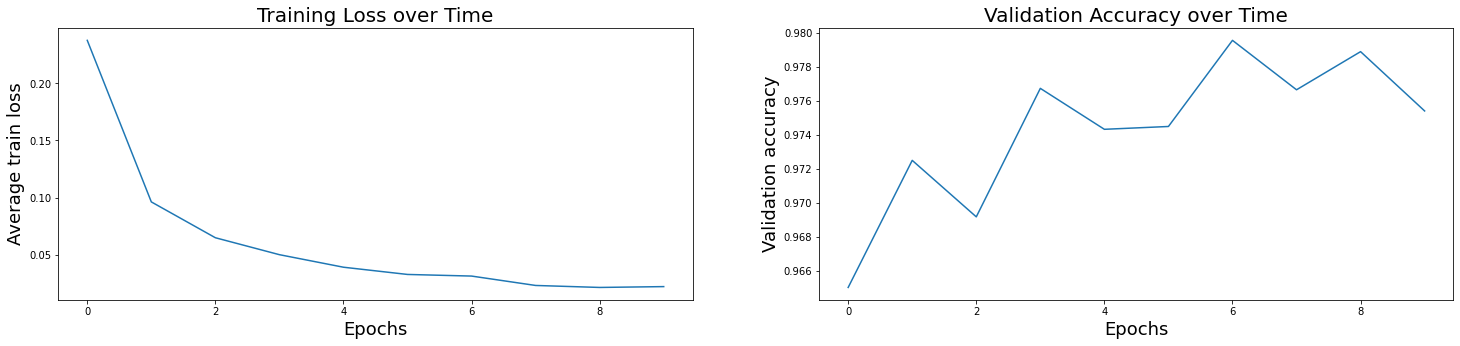

In [31]:
x_axis = np.arange(NUM_EPOCHS)

fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(w=25,h=5)
ax[0].plot(x_axis, train_history.history["loss"])
ax[0].set_xlabel('Epochs',fontsize=18)
ax[0].set_ylabel('Average train loss',fontsize=18)
ax[0].set_title('Training Loss over Time',fontsize=20)
ax[1].plot(x_axis, train_history.history["val_acc"])
ax[1].set_xlabel('Epochs',fontsize=18)
ax[1].set_ylabel('Validation accuracy',fontsize=18)
ax[1].set_title('Validation Accuracy over Time',fontsize=20)
fig.savefig('mnist_stats.png')


# Appendix: Defining the Neural Network from raw TensorFlow Ops

## Defining Hyperparameters

In [4]:
batch_size = 100 # how many datapoints we feed to the model in a single iteration
img_width, img_height = 28,28 # width and height of the images
input_size = img_height * img_width # total number of pixels
num_labels = 10 # number of classes

## Defining the Weights and Bias Variables

Here we define a list object that has a list of dictionaries. Dictionary at `i`th position has following items.
* `w` - Weights of the layer `i`
* `b` - Bias of the layer `i`

In [5]:
# Defining the Tensorflow variables
def define_net_parameters():
    params = []
    
    init = tf.keras.initializers.glorot_normal()
    params.append(
        {'w': tf.Variable(init([input_size,500])),
         'b': tf.Variable(init([500]))
        }
    )
        
    params.append(
        {'w': tf.Variable(init([500,250])),
         'b': tf.Variable(init([250]))
        }
    )
    
    params.append(
        {'w': tf.Variable(init([250,10])),
         'b': tf.Variable(init([10]))
        }
    )
    return params

params = define_net_parameters()

## Defining the Inference Operation

Here we calculate the output logits (unnormalized scores) for a given input x

In [6]:
# Defining calcutations in the neural network starting from inputs to logits
# logits are the values before applying softmax to the final output
@tf.function
def inference(x, params):
    h = x
    for layer in params[:-1]:
        w,b = layer["w"], layer["b"]
        h = tf.nn.relu(tf.matmul(h,w) + b)
    w,b = params[-1]["w"], params[-1]["b"]
    h = tf.matmul(h,w) + b
    
    return h

## Defining the Optimizer
We use the RMSprop optimizer for training the model

In [7]:
# defining the optimize function
optimizer = tf.optimizers.RMSprop()

## Training and Testing the Model

Here you'll be doing the following.

```
For each epoch:
  For each iteration:
    * Get a batch of inputs and targets (x and y_hot)
    * Compute the model output
    * Compute the loss in the context of GradientTape
    * Use the gradient of the loss to optimize the model
  For each test iteration:
    * Test the model accuracy with test inputs and targets
```

In [9]:
NUM_EPOCHS = 50

def accuracy(predictions, labels):
    ''' Measure the classification accuracy of some predictions (softmax outputs) 
    and labels (integer class labels)'''
    return np.sum(np.argmax(predictions,axis=1).flatten()==labels.flatten())/batch_size

test_accuracy_over_time = []
train_loss_over_time = []
for epoch in range(NUM_EPOCHS):
    train_loss = []
    
    # Training Phase 
    for step in range(train_inputs.shape[0]//batch_size):
        # Creating one-hot encoded labels with labels
        # One-hot encoding dight 3 for 10-class MNIST data set will result in
        # [0,0,0,1,0,0,0,0,0,0]
        x = train_inputs[step*batch_size: (step+1)*batch_size,:]
        y = train_labels[step*batch_size:(step+1)*batch_size]
        y_hot = np.zeros((batch_size, num_labels),dtype=np.float32)
        y_hot[np.arange(batch_size), y] = 1.0
        
        # Printing a sample of one-hot labels
        if epoch ==0 and step==0:
            print('Sample labels (one-hot)')
            print(y_hot[:10])
            print()
        
        # Using a gradient tape to record the gradients d(loss)/d(params)
        with tf.GradientTape() as tape:            
            # Computing the network output
            logits = inference(x, params)
            loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y_hot))
        
        # Making all parameters to a list
        all_params = []
        for dict in params:
            all_params.extend([dict["w"], dict["b"]])
        
        # Get the gradients of all parameters and apply that using an optimizer
        gradients = tape.gradient(loss, all_params)
        optimizer.apply_gradients(zip(gradients, all_params))        
        
        train_loss.append(loss) # Used to average the loss for a single epoch
        
    test_accuracy = []
    # Testing Phase
    for step in range(test_inputs.shape[0]//batch_size):
        ts_x = test_inputs[step*batch_size: (step+1)*batch_size,:]
        test_predictions = tf.nn.softmax(inference(ts_x, params))
        batch_test_accuracy = accuracy(test_predictions,test_labels[step*batch_size: (step+1)*batch_size])        
        test_accuracy.append(batch_test_accuracy)
    
    print('Average train loss for the %d epoch: %.3f\n'%(epoch+1,np.mean(train_loss)))
    train_loss_over_time.append(np.mean(train_loss))
    print('\tAverage test accuracy for the %d epoch: %.2f\n'%(epoch+1,np.mean(test_accuracy)*100.0))
    test_accuracy_over_time.append(np.mean(test_accuracy)*100)


Sample labels (one-hot)
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

Average train loss for the 1 epoch: 0.221

	Average test accuracy for the 1 epoch: 92.15

Average train loss for the 2 epoch: 0.087

	Average test accuracy for the 2 epoch: 94.62

Average train loss for the 3 epoch: 0.061

	Average test accuracy for the 3 epoch: 96.24

Average train loss for the 4 epoch: 0.046

	Average test accuracy for the 4 epoch: 96.64

Average train loss for the 5 epoch: 0.040

	Average test accuracy for the 5 epoch: 96.56

Average train loss for the 6 epoch: 0.034

	Average test accuracy for the 6 epoch: 96.83

Average train loss for the 7 epoch: 0.029

	Average test accuracy for the 7 epoch: 97.09

Average train 